In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ( classification_report, confusion_matrix, roc_auc_score, roc_curve,
                              precision_recall_fscore_support, accuracy_score
)
import joblib

In [3]:
train = pd.read_csv("LAP Train.csv")
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
train.shape

(614, 13)

In [6]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [7]:
train.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [8]:
for col in ["Gender", "Self_Employed", "Married", "Dependents"]:
    train[col].fillna(train[col].mode()[0], inplace=True)

for col in ["LoanAmount", "Loan_Amount_Term", "Credit_History"]:
    train[col].fillna(train[col].median(), inplace=True)

In [9]:
train['Loan_Status'].value_counts(normalize=True)

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

In [10]:
df = train.copy()

In [11]:
df['Loan_Status'] = df['Loan_Status'].map({'Y':1, 'N':0})

In [12]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


In [13]:
df["Dependents"].value_counts()

Dependents
0     360
1     102
2     101
3+     51
Name: count, dtype: int64

In [14]:
df['Dependents'] = df['Dependents'].replace('3+', 3).astype(float)

In [15]:
df['Total_income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['EMI'] = (df['LoanAmount']*1000) / df['Loan_Amount_Term']
df['Income_to_EMI'] = df['Total_income'] / (df['EMI'] + 1e-6)

In [25]:
target = 'Loan_Status'
features = [c for c in df.columns if c != target]

num_features = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Total_income','EMI','Income_to_EMI','Dependents']
cat_features = ['Gender','Married','Education','Self_Employed','Credit_History','Property_Area']

num_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

logreg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),   # ✅ fixed name + now defined
    ('clf', LogisticRegression(max_iter=1000))
])
                       

In [26]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size = 0.20, stratify = y, random_state = 42
)

logreg_pipe.fit(X_train, y_train)
y_pred = logreg_pipe.predict(X_test)
y_proba = logreg_pipe.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123

ROC AUC: 0.8479876160990713


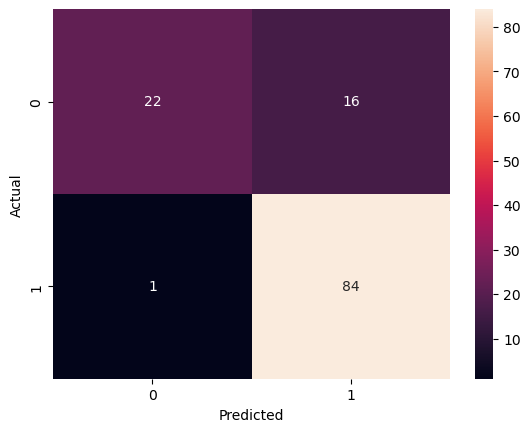

CV AUC: 0.7573106408555323


In [27]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

cv_auc = cross_val_score(logreg_pipe, X, y, cv=5, scoring = 'roc_auc')
print("CV AUC:", cv_auc.mean())

In [28]:
rf_pipe = Pipeline([('preprocessor', preprocessor),
                    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
print("RF report:")
print(classification_report(y_test, y_pred_rf))
print("RF ROC AUC:", roc_auc_score(y_test, rf_pipe.predict_proba(X_test)[:,1]))


RF report:
              precision    recall  f1-score   support

           0       0.86      0.66      0.75        38
           1       0.86      0.95      0.91        85

    accuracy                           0.86       123
   macro avg       0.86      0.81      0.83       123
weighted avg       0.86      0.86      0.86       123

RF ROC AUC: 0.8413312693498451


In [29]:
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 5, 10]
}
gs = GridSearchCV(rf_pipe, param_grid, cv=4, scoring='roc_auc', n_jobs=-1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV AUC:", gs.best_score_)


Best params: {'clf__max_depth': None, 'clf__n_estimators': 100}
Best CV AUC: 0.7602525237490407


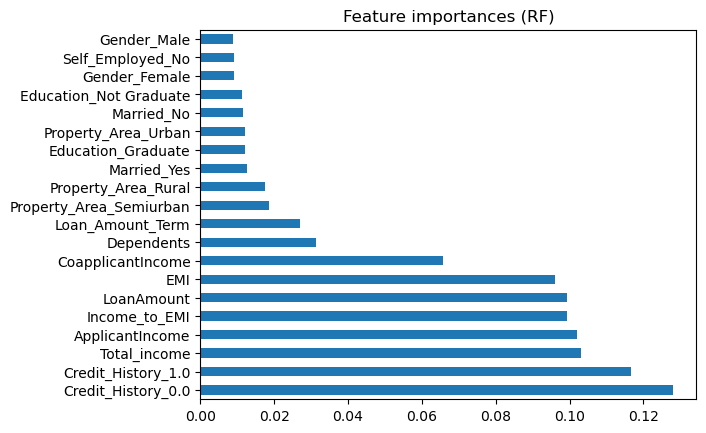

In [30]:
# feature names after one-hot encoding:
ohe = gs.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_cols = ohe.get_feature_names_out(cat_features)
num_cols = num_features
feature_names = np.concatenate([num_cols, ohe_cols])

importances = gs.best_estimator_.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
feat_imp.plot(kind='barh'); plt.title("Feature importances (RF)"); plt.show()


In [32]:
# save best trained pipeline (change to your best object)
best_model = gs.best_estimator_  # or rf_pipe, logreg_pipe as chosen
joblib.dump(best_model, "loan_approval_model.pkl")

['loan_approval_model.pkl']

In [34]:
# app.py
import streamlit as st
import pandas as pd
import joblib
import numpy as np

st.title("Loan Approval Predictor")
model = joblib.load("loan_approval_model.pkl")  # saved pipeline

# Input widgets (mirror features used)
gender = st.selectbox("Gender", ["Male","Female"])
married = st.selectbox("Married", ["Yes","No"])
dependents = st.selectbox("Dependents", ["0","1","2","3+"])
education = st.selectbox("Education", ["Graduate","Not Graduate"])
self_employed = st.selectbox("Self Employed", ["Yes","No"])
applicant_income = st.number_input("Applicant Income", min_value=0)
coapplicant_income = st.number_input("Coapplicant Income", min_value=0)
loan_amount = st.number_input("Loan Amount (thousands)", min_value=0)
loan_term = st.number_input("Loan Amount Term (days/months?)", min_value=0, value=360)
credit_history = st.selectbox("Credit History", [1.0, 0.0])
property_area = st.selectbox("Property Area", ["Urban","Semiurban","Rural"])

# derived features must match training preprocessing
total_income = applicant_income + coapplicant_income
emi = (loan_amount*1000) / (loan_term + 1e-6)
income_to_emi = total_income / (emi + 1e-6)

input_dict = {
    "Gender":[gender],
    "Married":[ 'Yes' if married=='Yes' else 'No'],
    "Dependents":[dependents],
    "Education":[education],
    "Self_Employed":[self_employed],
    "ApplicantIncome":[applicant_income],
    "CoapplicantIncome":[coapplicant_income],
    "LoanAmount":[loan_amount],
    "Loan_Amount_Term":[loan_term],
    "Credit_History":[credit_history],
    "Property_Area":[property_area],
    "Total_Income":[total_income],
    "EMI":[emi],
    "Income_to_EMI":[income_to_emi]
}

input_df = pd.DataFrame(input_dict)

if st.button("Predict"):
    prob = model.predict_proba(input_df)[0,1]
    pred = model.predict(input_df)[0]
    st.write(f"Probability of approval: {prob:.2f}")
    st.write("Prediction:", "Approved ✅" if pred==1 else "Rejected ❌")
